In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Study Station 235 Castrcum (Amsterdan) LSTM

In [2]:
import warnings
warnings.filterwarnings("ignore")

station = 235

In [7]:
from IPython.display import display, HTML
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

2023-04-08 15:53:34.102719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 15:53:34.226521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-04-08 15:53:34.226542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not 

In [4]:
def get_final_data(freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/agg/final/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

def get_specific_station_data(station, freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df = df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

In [5]:
def plot_autocorrelation(decomposition):
    
    ## can't plot autocorrelation for singular matrix
    if(decomposition.resid.values.sum() == 0):
        return
    
    ### Autocorrelation of residuals
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    # Calculate the histogram data (bin edges and counts)
    ax = sns.distplot(decomposition.resid, bins=12, kde=True, hist_kws={"alpha": 0.7})

    # Add labels to the histogram
    plt.xlabel('Precipitation')
    plt.ylabel('Frequency')
    plt.title('Precipitation Histogram')


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(decomposition.resid, lags=20, ax=ax1)
    plot_pacf(decomposition.resid, lags=20, ax=ax2)
    plt.show()


def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]


# LSTM

## Preparation and functions

> This will run an initial traning on all samples preselected during data prep. Disabled as it will take a few long hours

In [6]:
if(False):
    # List of stations from 02_dataprep. They have contiusly available data since 1955
    #stations_list = ['829', '467', '666', '447', '740', '747', '442', '743', '462', '234', '672', '543', '073', '434', '974', '356', '087', '348', '541', '970', '584', '443', '910', '737', '670', '139', '559', '352', '160', '012', '570', '539', '843', '742', '973', '964', '749', '458', '565', '067', '573', '075', '327', '221', '081', '897', '163', '912', '453', '224', '019', '667', '449', '046', '140', '549', '905', '736', '835', '558', '147', '839', '455', '328', '228', '669', '011', '756', '341', '329', '967', '678', '229', '066', '076', '354', '578', '464', '439', '837', '840', '345', '238', '456', '901', '913', '914', '827', '156', '338', '830', '963', '754', '755', '965', '834', '450', '471', '968', '461', '741', '437', '751', '665', '673', '896', '832', '090', '016', '833', '148', '240', '239', '158', '838', '236', '564', '567', '444', '562', '336', '068', '907', '358', '899', '550', '680', '561', '681', '342', '022', '454', '064', '668', '588', '750', '463', '077', '763', '010', '546', '563', '222', '911', '225', '235', '752', '746', '252', '056', '339', '844', '333', '915', '764', '831', '080', '760', '017', '583', '161', '758', '151', '082', '353', '579', '674', '828', '085', '664', '226', '340', '145', '330', '542', '332', '572', '084', '438']
    stations_list = ['080']
    stations_lstm_results = {}
    freq = 'M'
    for station in stations_list:

        # get data
        df_seasson = get_specific_station_data(station, freq)

        if(False): # Enable this for invidual analysis
            check_missing_values(df_seasson)


            # Seasonal Analysis
            display(HTML(f'<h1>Seasonal Analysis - {station}</h1>'))
            display(HTML('<hr/><br/>'))
            seasonality_plots(df_seasson,station,"1M",remove_outliers=False)

            # Decomposition Analysis
            display(HTML(f'<h1>Decomposition Analysis - {station}</h1>'))
            display(HTML('<hr/><br/>'))
            decomposition = plot_seasonlity(df_seasson)
            decomposition.resid.describe()

            # Plot autocorrelation
            plot_autocorrelation(decomposition)


        ## LSTM
        # Hyper parameters
        hyper_parameters = {
            'freq' : '1M',
            'look_back' : 12,
            'units' : 12,
            'dropout_rate' : 0.2,
            'optimizer' : 'adam'
        }

        stations_lstm_results[station] = run_training(df_seasson, hyper_parameters, True)
else:
    stations_lstm_results = {'829': 9999, '467': 9999, '666': 0.14214464, '447': 9999, '740': 9999, '747': 9999, '442': 9999, '743': 9999, '462': 0.1576759, '234': 0.17736025, '672': 9999, '543': 9999, '073': 0.19098094, '434': 9999, '974': 0.1589394, '356': 0.1683358, '087': 0.19192405, '348': 9999, '541': 9999, '970': 0.16780582, '584': 0.2025461, '443': 9999, '910': 9999, '737': 9999, '670': 9999, '139': 0.1573842, '559': 9999, '352': 0.15925187, '160': 9999, '012': 9999, '570': 9999, '539': 9999, '843': 0.16505456, '742': 9999, '973': 0.18139952, '964': 9999, '749': 0.1736844, '458': 9999, '565': 9999, '067': 9999, '573': 9999, '075': 0.18423764, '327': 9999, '221': 9999, '081': 0.18395138, '897': 9999, '163': 0.1640147, '912': 0.18016313, '453': 0.1496602, '224': 9999, '019': 0.18026893, '667': 9999, '449': 9999, '046': 0.19121893, '140': 9999, '549': 9999, '905': 9999, '736': 9999, '835': 9999, '558': 0.17719354, '147': 0.18407458, '839': 9999, '455': 9999, '328': 0.1507474, '228': 0.157815, '669': 9999, '011': 0.18046126, '756': 9999, '341': 0.15391526, '329': 9999, '967': 9999, '678': 0.1715598, '229': 9999, '066': 9999, '076': 9999, '354': 0.14207321, '578': 0.18097365, '464': 0.14910223, '439': 9999, '837': 9999, '840': 0.18391009, '345': 0.13900559, '238': 9999, '456': 0.14702083, '901': 9999, '913': 9999, '914': 9999, '827': 9999, '156': 0.14652579, '338': 0.13322017, '830': 9999, '963': 9999, '754': 9999, '755': 9999, '965': 9999, '834': 0.1704336, '450': 9999, '471': 9999, '968': 0.15925732, '461': 9999, '741': 9999, '437': 0.15339538, '751': 9999, '665': 9999, '673': 9999, '896': 9999, '832': 9999, '090': 0.19622971, '016': 9999, '833': 9999, '148': 9999, '240': 0.1870525, '239': 9999, '158': 9999, '838': 0.16531673, '236': 9999, '564': 9999, '567': 9999, '444': 0.1775532, '562': 9999, '336': 9999, '068': 9999, '907': 9999, '358': 0.14910142, '899': 0.17625822, '550': 0.16978025, '680': 0.15163502, '561': 9999, '681': 0.14619893, '342': 9999, '022': 0.1539157, '454': 0.1949879, '064': 9999, '668': 9999, '588': 0.16878334, '750': 9999, '463': 0.16534059, '077': 9999, '763': 0.17807491, '010': 9999, '546': 9999, '563': 9999, '222': 0.18780243, '911': 0.18083245, '225': 0.1534206, '235': 0.18897787, '752': 9999, '746': 9999, '252': 9999, '056': 0.18388759, '339': 9999, '844': 0.18160371, '333': 9999, '915': 0.16940638, '764': 0.16919768, '831': 9999, '080': 0.13211404, '760': 0.17741859, '017': 9999, '583': 9999, '161': 0.1533159, '758': 0.18230926, '151': 9999, '082': 0.17550059, '353': 0.14426473, '579': 0.17034939, '674': 0.14492266, '828': 0.15343612, '085': 0.15361921, '664': 9999, '226': 9999, '340': 9999, '145': 0.17445874, '330': 0.17149243, '542': 0.15995637, '332': 9999, '572': 0.16954, '084': 0.1673286, '438': 0.15331575}
#print(stations_lstm_results[station])

In [8]:
def get_scaled_data(df_seasson):
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_seasson)
    return scaled_data


def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def create_rnn(units, look_back, optimizer, activation='tanh', recurrent_activation='sigmoid'):
    model = Sequential()
    
    model.add(LSTM(units, input_shape=(look_back, 1), activation=activation, recurrent_activation=recurrent_activation, return_sequences=True))
    #model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, activation=activation, recurrent_activation=recurrent_activation, return_sequences = True))
    #model.add(Dropout(0.2))

    model.add(LSTM(units = units, activation=activation, recurrent_activation=recurrent_activation, return_sequences = True))
    #model.add(Dropout(0.2))

    model.add(LSTM(units))
    #model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

def run_training(df, hyper_parameters, plot_result = False):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping
    
    look_back = hyper_parameters['look_back']

    # Split dataset for test and training and create sequences.
    train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

    # Create training and test sequences
    train_X, train_y = create_sequences(train_data, look_back)
    test_X, test_y = create_sequences(test_data, look_back)

    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

    # Create CNN model
    model = create_rnn(hyper_parameters)

    # Configure early stop
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=0, validation_split=0.2, callbacks=[early_stopping])


    predictions = model.predict(test_X)
    rmse = 9999
    if(np.any(np.isnan(predictions.flatten())) == False):
        rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
        
    if(plot_result):
        plt.figure(figsize=(12, 6))
        plt.plot(test_y, label='Actual values')
        plt.plot(predictions, label='Predictions', linestyle='dashed')
        plt.xlabel('Time Steps')
        plt.ylabel('Scaled Precipitation')
        plt.legend()
        plt.show()
        
    return rmse;

## Stations 235

In [18]:
# Hyper parameters
hyper_parameters = {
    'freq' : '4w',
    'look_back' : 26,
    'units' : 26,
    'dropout_rate' : 0.2,
    'optimizer' : Adam(learning_rate=0.001)
}


In [20]:
# Get Dataset
station = 235
df = get_specific_station_data(station,hyper_parameters['freq'],1800)
scaled_data = get_scaled_data(df)

look_back = hyper_parameters['look_back']

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, look_back)
test_X, test_y = create_sequences(test_data, look_back)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

# Create CNN model
model = create_rnn(units = hyper_parameters['units'],
                   look_back = hyper_parameters['look_back'],
                   optimizer = hyper_parameters['optimizer'],
                   activation=None,
                   recurrent_activation=None
                )

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=1, validation_split=0.2, callbacks=[early_stopping])


predictions = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
print(f"RMSE: {rmse}")

Epoch 1/100
156/156 [==============================] - 8s 29ms/step - loss: 0.0203 - val_loss: 0.0282
Epoch 2/100
156/156 [==============================] - 4s 25ms/step - loss: 0.0171 - val_loss: 0.0260
Epoch 3/100
156/156 [==============================] - 4s 25ms/step - loss: 0.0170 - val_loss: 0.0262
Epoch 4/100
156/156 [==============================] - 4s 26ms/step - loss: 0.0170 - val_loss: 0.0268
Epoch 5/100
156/156 [==============================] - 4s 25ms/step - loss: 0.0168 - val_loss: 0.0240
Epoch 6/100
156/156 [==============================] - 4s 25ms/step - loss: 0.0174 - val_loss: 0.0251
Epoch 7/100
156/156 [==============================] - 4s 25ms/step - loss: 0.0169 - val_loss: 0.0239
Epoch 8/100
156/156 [==============================] - 4s 26ms/step - loss: 0.0172 - val_loss: 0.0244
Epoch 9/100
156/156 [==============================] - 4s 26ms/step - loss: 0.0169 - val_loss: 0.0268
Epoch 10/100
156/156 [==============================] - 4s 25ms/step - loss: 0.017

RMSE: 0.1592966765165329


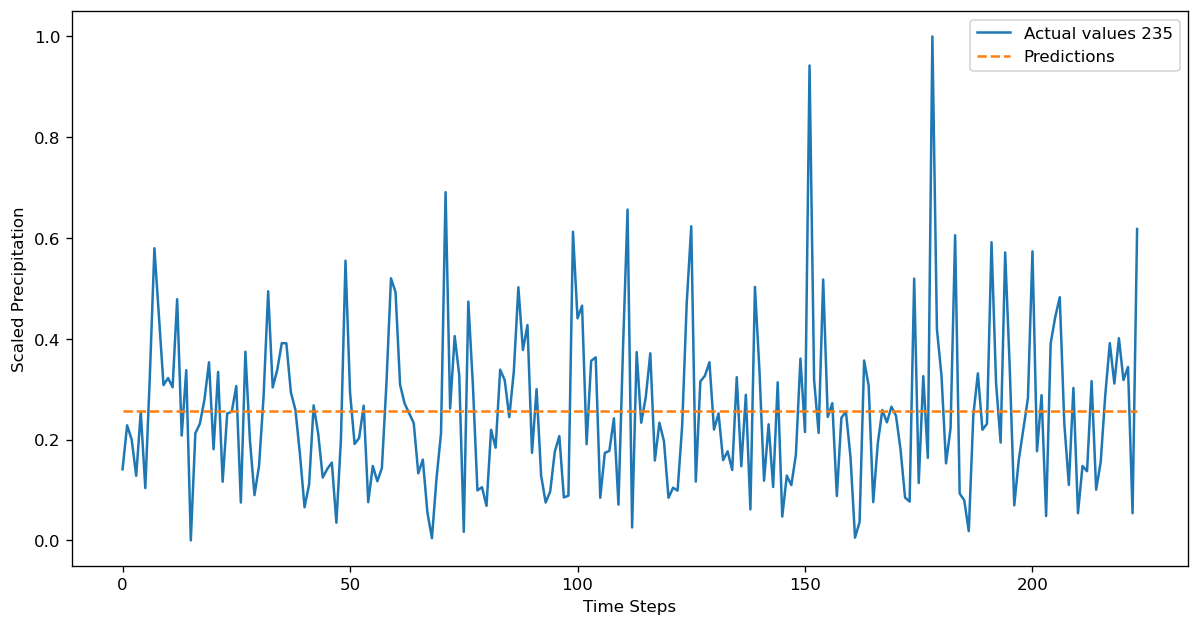

In [21]:
print(f"RMSE: {rmse}")
plt.figure(figsize=(12, 6))
plt.plot(test_y, label=f'Actual values {station}')
plt.plot(predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()

##  Copmbined stations

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Get Dataset
station = 235
df = get_final_data(hyper_parameters['freq'], 1951)
scaled_data = get_scaled_data(df)

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, look_back)
test_X, test_y = create_sequences(test_data, look_back)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

# Create CNN model
model = create_rnn(units = hyper_parameters['units'],
                   look_back = hyper_parameters['look_back'],
                   optimizer = hyper_parameters['optimizer'],
                   activation=None,
                   recurrent_activation=None
                )

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=1, validation_split=0.2, callbacks=[early_stopping])


predictions = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
print(f"RMSE: {rmse}")

Epoch 1/100
108/108 [==============================] - 5s 23ms/step - loss: 0.0378 - val_loss: 0.0309
Epoch 2/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0317 - val_loss: 0.0336
Epoch 3/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0315 - val_loss: 0.0293
Epoch 4/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0312 - val_loss: 0.0281
Epoch 5/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0309 - val_loss: 0.0333
Epoch 6/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0316 - val_loss: 0.0286
Epoch 7/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0312 - val_loss: 0.0306
Epoch 8/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0315 - val_loss: 0.0285
Epoch 9/100
108/108 [==============================] - 2s 18ms/step - loss: 0.0319 - val_loss: 0.0306
Epoch 10/100
108/108 [==============================] - 2s 18ms/step - loss: 0.031

RMSE: 0.18610376119613647


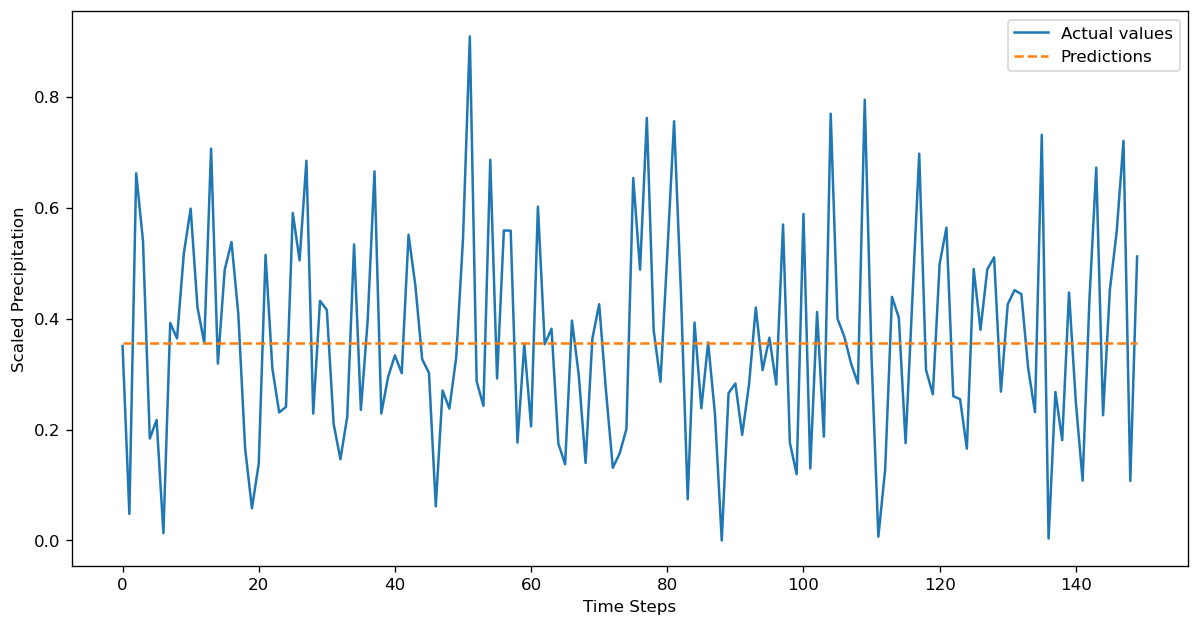

In [26]:
print(f"RMSE: {rmse}")
plt.figure(figsize=(12, 6))
plt.plot(test_y, label='Actual values')
plt.plot(predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()

## Hyper parameter tunning - 235 - 4weeks frequency

In [ ]:
import time

# Best params from last run. This can take few hours
runTunning = True
best_params_ = {
     'activation': 'tanh',
     'batch_size': 50,
     'epochs': 50,
     'look_back': 26,
     'optimizer': 'adam',
     'recurrent_activation': 'sigmoid',
     'units': 50
}

# record the start time
start_time = time.time()  
if(runTunning):
    # Aggregate data on a monthly basis
    station = 235
    df = get_specific_station_data(station,hyper_parameters['freq'], 1800) # ALL DATA AVAILABLE
    scaled_data = get_scaled_data(df)

    # Split dataset for test and training and create sequences.
    train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

    # Create train and test datasets
    X_train, y_train = create_sequences(train_data, look_back)
    X_test, y_test = create_sequences(test_data, look_back)

    # Reshape data for CNN input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Perform hyperparameter tuning
    model = KerasRegressor(build_fn=create_rnn, verbose=0)
    param_grid = {
        'look_back' : [12, hyper_parameters['look_back'], 32],
        'epochs': [50],
        'batch_size': [16, 50],
        'units' : [3, 5, 12, 26, 32],
        'optimizer': ['adam','rmsrop','adadelta'],
        'recurrent_activation' : [None,'sigmoid'],
        'activation' :  [None,'tanh','relu'],

    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)
    best_params_ = grid_result.best_params_

# record the end time
end_time = time.time() 
elapsed_time = end_time - start_time  # calculate the elapsed time
print("Elapsed time: ", elapsed_time * 60, " minutes")

print(f"Best Params:")
best_params_

2023-04-08 17:15:56.951120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 17:15:57.003170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 17:15:57.018789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

### Run final model

In [ ]:
station = 235
df = get_final_data(hyper_parameters['freq'][stage], 1800)
look_back = hyper_parameters['look_back'][stage]
scaled_data = get_scaled_data(df)

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(best_params_)
# Train the model
best_epochs = best_params_['epochs']
best_batch_size = best_params_['batch_size']
#model = create_model_t(units =  best_params_['units'],
#                       look_back = best_params_['look_back'],
#                       optimizer = best_params_['optimizer'],
#                       activation = best_params_['activation'],
#                       recurrent_activation = best_params_['recurrent_activation'])

hyper_parameters = {
    'freq' : ['1d','5d', '7d', '4w', '1M', '14w'],
    'look_back' : [365, 73, 57, 26, 12, 36],
    'units' : [365, 73, 57, 26, 12, 6],
    'dropout_rate' : 0.2,
    'optimizer' : Adam(learning_rate=0.001)
}
stage = 3

model = create_rnn(hyper_parameters)

# Include Early Stop if learning doesn't improve on delta 0.00001 after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
# Predict precipitation using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
train_mase = train_mae / (np.mean(np.abs(y_train[1:] - y_train[:-1])))

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mase = test_mae / (np.mean(np.abs(y_test[1:] - y_test[:-1])))

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")
print(f"Train MASE: {train_mase:.2f}, Test MASE: {test_mase:.2f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual values')
plt.plot(test_predict, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()


## Error functions definition

\begin{equation}
\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
\end{equation}

\begin{equation}
\mathrm{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
\end{equation}

\begin{equation}
\mathrm{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right| \times 100\%
\end{equation}


\begin{equation}
\mathrm{MASE} = \frac{\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|}{\frac{1}{n-m}\sum_{i=m+1}^{n}|y_i - y_{i-m}|}
\end{equation}



